In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from pathlib import Path

cache_path = Path("C:\\tempjeka\\cache")

<IPython.core.display.Javascript object>

In [3]:
import os

os.environ["TORCH_HOME"] = str(cache_path / "models")
os.environ["HF_HOME"] = str(cache_path / "huggingface")
os.environ["HUGGINGFACE_HUB_CACHE"] = str(cache_path / "huggingface")
os.environ["TRANSFORMERS_CACHE"] = str(cache_path / "huggingface")
os.environ["HF_DATASETS_CACHE"] = str(cache_path / "huggingface")

<IPython.core.display.Javascript object>

In [4]:
import pytorch_lightning as pl
import wget
from datasets import Dataset, load_dataset, DatasetDict, load_metric
import torch.utils.data as td
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM
import torch
from torchinfo import summary
import torch.nn as nn
from copy import deepcopy
import evaluate
from tqdm import tqdm
import numpy as np

<IPython.core.display.Javascript object>

In [5]:
batch_size = 32

<IPython.core.display.Javascript object>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda"

<IPython.core.display.Javascript object>

In [7]:
data_folder = Path("data")
en_ru_data_path = data_folder / "en-ru.txt"
if not en_ru_data_path.exists():
    data_folder.mkdir(exist_ok=True)
    wget.download(
        "https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt",
        out=str(en_ru_data_path),
    )

<IPython.core.display.Javascript object>

In [8]:
class TranslationDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = None

        self.source_lang = "en"
        self.target_lang = "ru"
        self.max_input_length = 128
        self.max_target_length = 128
        self.prefix = ""

    @staticmethod
    def _dataset_convert_csv():
        with open(en_ru_data_path, encoding="utf8") as f:
            lines = f.readlines()
        for line in lines:
            en, ru = line.split("\t")
            yield dict(translation=dict(en=en, ru=ru))

    def preprocess_function(self, examples):
        inputs = [self.prefix + ex[self.source_lang] for ex in examples["translation"]]
        targets = [ex[self.target_lang] for ex in examples["translation"]]
        model_inputs = self.tokenizer(
            inputs,
            max_length=self.max_input_length,
            truncation=True,
            padding=True,
        )

        labels = self.tokenizer(
            text_target=targets,
            max_length=self.max_target_length,
            truncation=True,
            padding=True,
        )

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    def prepare_data(self):
        AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
        Dataset.from_generator(
            self._dataset_convert_csv, cache_dir=os.environ["HF_DATASETS_CACHE"]
        )
        AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")

    def setup(self, stage: str = None):
        self.collator = DataCollatorForSeq2Seq(
            AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
        )

        self.tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")

        test = Dataset.from_generator(
            self._dataset_convert_csv, cache_dir=os.environ["HF_DATASETS_CACHE"]
        ).train_test_split(0.2, seed=0)
        val = test["test"].train_test_split(0.5, seed=0)
        self.dataset = DatasetDict(
            dict(test=val["test"], train=test["train"], val=val["train"])
        ).map(
            lambda ex: self.preprocess_function(ex),
            batched=True,
            load_from_cache_file=True,
        )

        return self

    def train_dataloader(self):
        return td.DataLoader(
            self.dataset["train"].remove_columns("translation"),
            batch_size=self.batch_size,
            collate_fn=self.collator,
        )

    def val_dataloader(self):
        return td.DataLoader(
            self.dataset["val"].remove_columns("translation"),
            batch_size=self.batch_size,
            collate_fn=self.collator,
        )

    def test_dataloader(self):
        return td.DataLoader(
            self.dataset["test"].remove_columns("translation"),
            batch_size=self.batch_size,
            collate_fn=self.collator,
        )

    #     def predict_dataloader(self):
    #         return td.DataLoader(self.dataset["test"], batch_size=self.batch_size)

    def teardown(self, stage: str):
        ...


check_data_module = TranslationDataModule()
check_data_module.prepare_data()
check_data_module.setup()
check_batch = next(iter(check_data_module.test_dataloader()))
check_batch

C:\Users\santix\AppData\Roaming\Python\Python310\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-6d4dfb1951065dd4/0.0.0)
Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-6d4dfb1951065dd4/0.0.0)
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-6d4dfb1951065dd4\0.0.0\cache-1411fe41ed19d2e2.arrow and C:\tempjeka\cache\huggingface\generator\default-6d4dfb1951065dd4\0.0.0\cache-68cd02c5f8d86800.arrow
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-6d4dfb1951065dd4\0.0.0\cache-6ebe3cd1bb6dfaae.arrow and C:\tempjeka\cache\huggingface\generator\default-6d4dfb1951065dd4\0.0.0\cache-1150fe294921b468.arrow
Loading cached processed dataset at C:\tempjeka\cache\huggingface\genera

{'input_ids': tensor([[   32,  9732, 47193,  ..., 62517, 62517, 62517],
        [   86,  1349,    11,  ..., 62517, 62517, 62517],
        [   32,  2125,    88,  ..., 62517, 62517, 62517],
        ...,
        [54410,   136,  3356,  ..., 62517, 62517, 62517],
        [  289, 34809,  6532,  ..., 62517, 62517, 62517],
        [   32, 17219,  2759,  ..., 62517, 62517, 62517]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[   49,  5633,  9167,  ..., 62517, 62517, 62517],
        [  246,  6513,  1420,  ..., 62517, 62517, 62517],
        [ 6766,    48,   300,  ..., 62517, 62517, 62517],
        ...,
        [ 2335, 18355,   387,  ..., 62517, 62517, 62517],
        [ 1110,  2390,  4041,  ..., 62517, 62517, 62517],
        [  293,  5900, 30994,  ..., 62517, 62517, 62517]])}

<IPython.core.display.Javascript object>

In [9]:
base_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-ru").to(
    device
)
metric = evaluate.load("bleu")
base_model.eval()
with torch.no_grad():
    for batch in (pbar := tqdm(check_data_module.test_dataloader(), ncols=100)):
        batch.to(device)
        pred = check_data_module.tokenizer.batch_decode(
            base_model.generate(**batch),
            skip_special_tokens=True,
        )
        ref = check_data_module.tokenizer.batch_decode(
            batch["labels"], skip_special_tokens=True
        )
        metric.add_batch(references=ref, predictions=pred)
#         pbar.set_postfix({"bleu": metric.compute()["bleu"] * 100})
print(metric.compute())  # 0.133
del base_model

  0%|                                                                       | 0/157 [00:00<?, ?it/s]C:\Users\santix\AppData\Roaming\Python\Python310\site-packages\transformers\generation\utils.py:1313: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████| 157/157 [04:59<00:00,  1.90s/it]


{'bleu': 0.13310420572751333, 'precisions': [0.4111725801755335, 0.18375221608092607, 0.10723886483267067, 0.06400112036972201], 'brevity_penalty': 0.8820488729155654, 'length_ratio': 0.8884878349245457, 'translation_length': 72123, 'reference_length': 81175}


<IPython.core.display.Javascript object>

In [9]:
class TranslationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
        for p in self.model.parameters():
            p.requires_grad = False

        block = deepcopy(self.model.model.decoder.layers[5])
        self.model.model.decoder.layers.append(block)
        for p in block.parameters():
            p.requires_grad = True

        block = deepcopy(self.model.model.encoder.layers[5])
        self.model.model.encoder.layers.append(block)
        for p in block.parameters():
            p.requires_grad = True
        block = deepcopy(self.model.model.encoder.layers[5])
        self.model.model.encoder.layers.append(block)
        for p in block.parameters():
            p.requires_grad = True

    def generate(self, **batch):
        return self.model.generate(**batch)

    def forward(self, x):
        out = self.model(**x)
        return out

    def step(self, batch, batch_idx, metric, prog_bar=True):
        out = self.forward(batch)
        loss = out.loss
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=True):
        out = self.forward(batch)
        loss = out.loss
        self.log("test_loss", loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
#         lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
#         scheduler = {
#             "scheduler": lr_scheduler,
#             "monitor": "val_loss",
#         }
        return dict(optimizer=optimizer)


check_model = TranslationModel().to(device)
# summary(check_model, input_data=[check_batch], verbose=2)
# check_model(check_batch)
# (
#     check_data_module.tokenizer.batch_decode(
#         check_model.generate(**check_batch),
#         skip_special_tokens=True,
#     ),
#     check_data_module.tokenizer.batch_decode(check_batch["labels"]),
# )
# check_model

<IPython.core.display.Javascript object>

In [10]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    callbacks=[
        #         pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=3),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback,
    ],
    logger=pl.loggers.TensorBoardLogger(save_dir="../made/logs"),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<IPython.core.display.Javascript object>

In [11]:
trainer.fit(check_model, check_data_module)

C:\Users\santix\AppData\Roaming\Python\Python310\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-6d4dfb1951065dd4/0.0.0)
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-6d4dfb1951065dd4/0.0.0)
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-6d4dfb1951065dd4\0.0.0\cache-1411fe41ed19d2e2.arrow and C:\tempjeka\cache\huggingface\generator\defau

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | MarianMTModel | 87.2 M
----------------------------------------
10.5 M    Trainable params
76.7 M    Non-trainable params
87.2 M    Total params
348.723   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\tempjeka\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\tempjeka\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
best = TranslationModel.load_from_checkpoint(checkpoint_callback.best_model_path)
torch.save(best.state_dict(), Path("models") / "a.pt")

In [13]:
best = TranslationModel()
best.load_state_dict(torch.load(Path("models") / "a.pt"))
best.to(device)
best.eval()

In [15]:
metric = evaluate.load("bleu")
best.eval()
with torch.no_grad():
    for batch in (pbar := tqdm(check_data_module.test_dataloader(), ncols=100)):
        batch.to(device)
        pred = check_data_module.tokenizer.batch_decode(
            best.generate(**batch),
            skip_special_tokens=True,
        )
        ref = check_data_module.tokenizer.batch_decode(
            batch["labels"], skip_special_tokens=True
        )
        metric.add_batch(references=ref, predictions=pred)
metric = metric.compute()
print(metric)  # 0.302

In [18]:
metric

{'bleu': 0.30156776749076736,
 'precisions': [0.6003573721975598,
  0.391061620193895,
  0.2851186033682708,
  0.21049193064237032],
 'brevity_penalty': 0.8752979442687874,
 'length_ratio': 0.882463812750231,
 'translation_length': 71634,
 'reference_length': 81175}

<IPython.core.display.Javascript object>

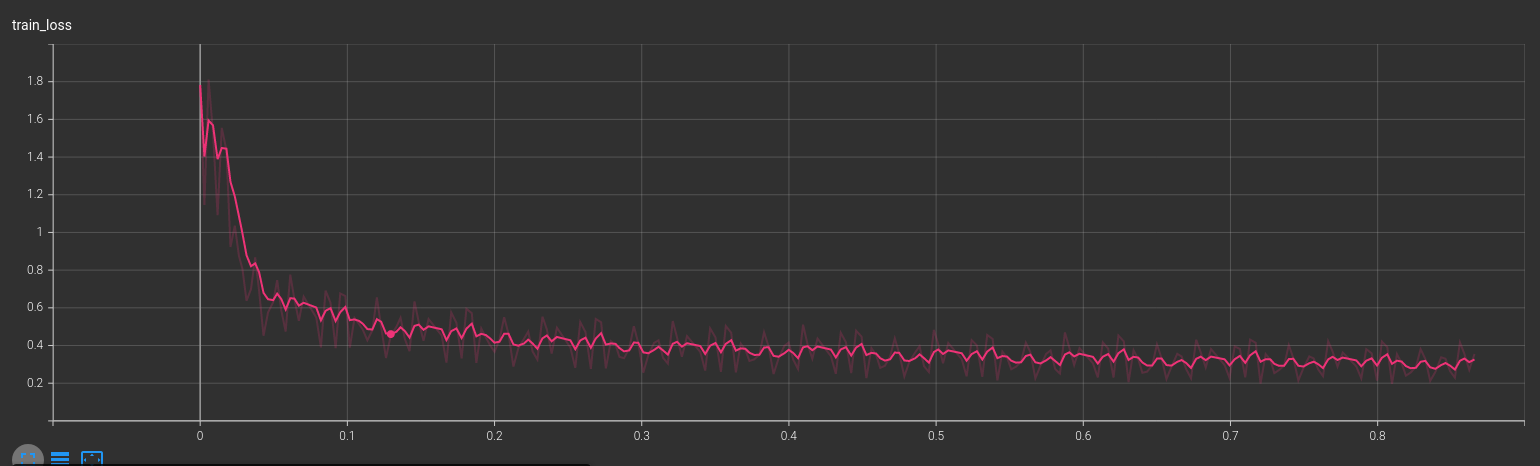

## 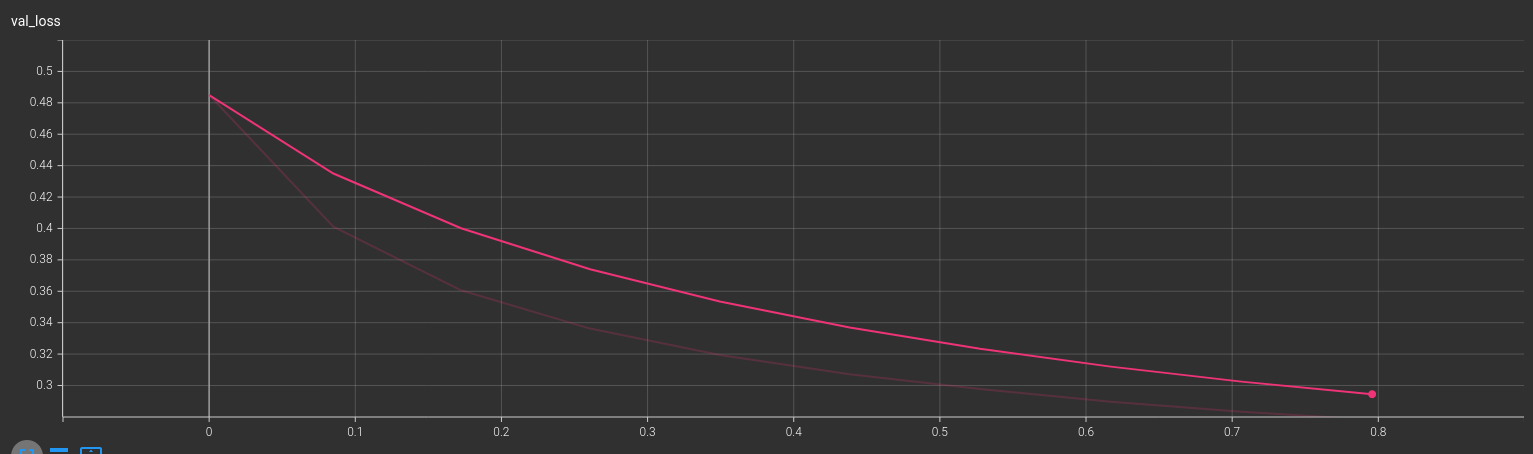